# Spectral Analysis

In [21]:
import Simulator
import Observation
import Statistics
import KalmanFilter

## Loading simulator 

For Kalman filtering we have to be able to propagate a Gaussian distribution in time and to have access to the linear operators

In [22]:
timestamp = "2022_03_02-12_44_46"

grid, simulator = Simulator.from_file(timestamp)

## Definition of initial distribution 

The inital state is equipped with a Gaussian distribution specified by its mean and covariance. 

In [23]:
statistics = Statistics.Statistics(simulator, safe_history=True)
prior_args = Statistics.prior_args_from_file(timestamp)
statistics.set_prior(prior_args)

Please remember to set priors!


In [24]:
obs_timestamp = "2022_03_02-12_44_53"
observation = Observation.from_file(grid, timestamp, obs_timestamp)

Remember to set observation positions and to set/observe values!


### KF in time

In [25]:
# Plots for the paper
import numpy as np
kf_prior_means = np.zeros((11,grid.N_x))
kf_prior_covs = np.zeros((11,grid.N_x,grid.N_x))

kf_posterior_means = np.zeros((11,grid.N_x))
kf_posterior_covs = np.zeros((11,grid.N_x,grid.N_x))

In [26]:
kf_prior_means[0] = statistics.mean
kf_prior_covs[0]  = statistics.cov

kalmanFilter = KalmanFilter.Kalman(statistics, observation)

kf_posterior_means[0] = statistics.mean
kf_posterior_covs[0]  = statistics.cov

for t in range(observation.N_obs):
    print(t)
    statistics.propagate(25)

    kf_prior_means[t+1] = statistics.mean
    kf_prior_covs[t+1]  = statistics.cov

    kalmanFilter.filter(statistics.mean, statistics.cov, observation.obses[t])

    kf_posterior_means[t+1] = statistics.mean
    kf_posterior_covs[t+1]  = statistics.cov

0
1
2
3
4
5
6
7
8
9


/home/florianb/miniconda3/envs/advecdiff/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/florianb/miniconda3/envs/advecdiff/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/florianb/miniconda3/envs/advecdiff/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/florianb/miniconda3/envs/advecdiff/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/florianb/miniconda3/envs/advecdiff/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the 

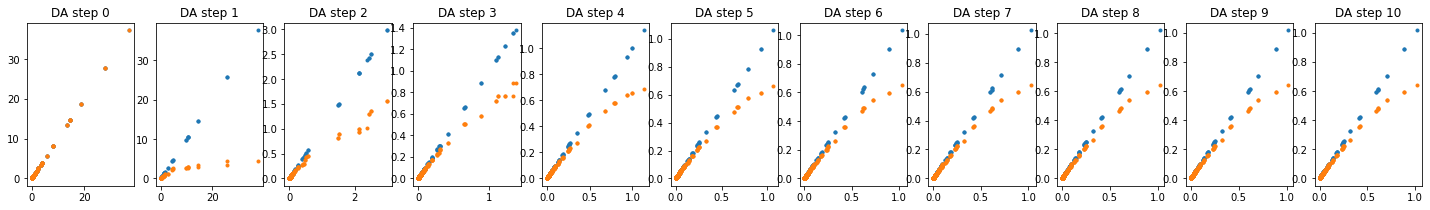

In [27]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 11, figsize=(25,3))
for t in range(11):
    prior_w = np.sort(np.linalg.eig(kf_prior_covs[t])[0])
    posterior_w = np.sort(np.linalg.eig(kf_posterior_covs[t])[0])
    axs[t].plot(prior_w, prior_w, ".")
    axs[t].plot(prior_w, posterior_w, ".")
    axs[t].set_title("DA step " + str(t))

### First Ensemble Step

All sharing same prior

In [28]:
N_e = 50

In [29]:
ensemble_statistics = Statistics.Statistics(simulator, N_e, safe_history=True)
prior_args = Statistics.prior_args_from_file(timestamp)
ensemble_statistics.set_prior(prior_args)


In [30]:
ensemble_statistics.propagate(25, model_error=False)

Model error in historical forecast added


In [31]:
import copy
unpert_prior_ensemble = copy.deepcopy(ensemble_statistics.ensemble.ensemble)
pert_prior_ensemble = unpert_prior_ensemble + ensemble_statistics.simulator.noise_sampler.sample(N_e)

In [32]:
import ETKalmanFilter
etkFilter = ETKalmanFilter.ETKalman(ensemble_statistics, observation)
posterior_etkf = etkFilter.filter(pert_prior_ensemble, observation.obses[0])

In [33]:
import SLETKalmanFilter
sletkFilter = SLETKalmanFilter.SLETKalman(ensemble_statistics, observation, 6)
posterior_letkf = sletkFilter.filter(pert_prior_ensemble, observation.obses[0])

In [34]:
import IEWParticleFilter
iewpFilter = IEWParticleFilter.IEWParticle(ensemble_statistics, observation, beta=0.55)
posterior_iewpf = iewpFilter.filter(unpert_prior_ensemble, observation.obses[0])

In [35]:
def estimateCov(states):
    return 1/(states.shape[-1]-1)*(states - np.average(states, axis=-1)[:,np.newaxis]) @ ((states - np.average(states,axis=-1)[:,np.newaxis]).T)

/home/florianb/miniconda3/envs/advecdiff/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/florianb/miniconda3/envs/advecdiff/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/florianb/miniconda3/envs/advecdiff/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/florianb/miniconda3/envs/advecdiff/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/florianb/miniconda3/envs/advecdiff/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the 

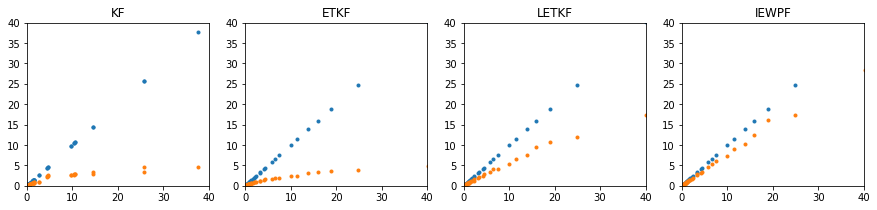

In [36]:
fig, axs = plt.subplots(1, 4, figsize=(15,3))

kf_prior_w = np.sort(np.linalg.eig(kf_prior_covs[1])[0])
kf_posterior_w = np.sort(np.linalg.eig(kf_posterior_covs[1])[0])
axs[0].plot(kf_prior_w, kf_prior_w, ".")
axs[0].plot(kf_prior_w, kf_posterior_w, ".")
axs[0].set_title("KF")

ensemble_prior_w = np.sort(np.linalg.eig(estimateCov(pert_prior_ensemble))[0])
etkf_posterior_w = np.sort(np.linalg.eig(estimateCov(posterior_etkf))[0])
letkf_posterior_w = np.sort(np.linalg.eig(estimateCov(posterior_letkf))[0])
iewpf_posterior_w = np.sort(np.linalg.eig(estimateCov(posterior_iewpf))[0])
axs[1].plot(ensemble_prior_w, ensemble_prior_w, ".")
axs[2].plot(ensemble_prior_w, ensemble_prior_w, ".")
axs[3].plot(ensemble_prior_w, ensemble_prior_w, ".")

axs[1].plot(ensemble_prior_w, etkf_posterior_w, ".")
axs[1].set_title("ETKF")
axs[2].plot(ensemble_prior_w, letkf_posterior_w, ".")
axs[2].set_title("LETKF")
axs[3].plot(ensemble_prior_w, iewpf_posterior_w, ".")
axs[3].set_title("IEWPF")

for i in range(4):
    axs[i].set_ylim((0,40))
    axs[i].set_xlim((0,40))

In [41]:
np.savetxt("eigKFprior.csv", np.real(np.vstack([kf_prior_w, kf_prior_w]).T),delimiter=' ', newline='\n',  fmt='%1.8f')
np.savetxt("eigKFposterior.csv", np.real(np.vstack([kf_prior_w, kf_posterior_w]).T),delimiter=' ', newline='\n',  fmt='%1.8f')

np.savetxt("eigEprior.csv", np.real(np.vstack([ensemble_prior_w, ensemble_prior_w]).T),delimiter=' ', newline='\n',  fmt='%1.8f')
np.savetxt("eigETKFposterior.csv", np.real(np.vstack([ensemble_prior_w, etkf_posterior_w]).T),delimiter=' ', newline='\n',  fmt='%1.8f')
np.savetxt("eigLETKFposterior.csv", np.real(np.vstack([ensemble_prior_w, letkf_posterior_w]).T),delimiter=' ', newline='\n',  fmt='%1.8f')
np.savetxt("eigIEWPFposterior.csv", np.real(np.vstack([ensemble_prior_w, iewpf_posterior_w]).T),delimiter=' ', newline='\n',  fmt='%1.8f')

## Ensembles in time

In [38]:
prior_states_etkf = np.zeros((11, 1500, N_e))
posterior_states_etkf = np.zeros((11, 1500, N_e))

prior_states_letkf = np.zeros((11, 1500, N_e))
posterior_states_letkf = np.zeros((11, 1500, N_e))

prior_states_iewpf = np.zeros((11, 1500, N_e))
posterior_states_iewpf = np.zeros((11, 1500, N_e))

In [39]:

# ETKF 
print("ETKF DA")
statistics_etkf = Statistics.Statistics(simulator, N_e, safe_history=True)
statistics_etkf.set_prior(prior_args)

etkFilter = ETKalmanFilter.ETKalman(statistics_etkf, observation)

for t in range(observation.N_obs):
    statistics_etkf.propagate(25)
    prior_states_etkf[t+1] = statistics_etkf.ensemble.ensemble
    etkFilter.filter(statistics_etkf.ensemble.ensemble, observation.obses[t])
    posterior_states_etkf[t+1] = statistics_etkf.ensemble.ensemble

# LETKF
print("LETKF DA")
statistics_letkf = Statistics.Statistics(simulator, N_e, safe_history=True)
statistics_letkf.set_prior(prior_args) 

sletkFilter = SLETKalmanFilter.SLETKalman(statistics_letkf, observation, 6)

for t in range(observation.N_obs):
    statistics_letkf.propagate(25)
    prior_states_letkf[t+1] = statistics_letkf.ensemble.ensemble
    sletkFilter.filter(statistics_letkf.ensemble.ensemble, observation.obses[t])
    posterior_states_letkf[t+1] = statistics_letkf.ensemble.ensemble

# IEWPF
print("IEWPF DA")
statistics_iewpf = Statistics.Statistics(simulator, N_e, safe_history=True)
statistics_iewpf.set_prior(prior_args)

iewpFilter = IEWParticleFilter.IEWParticle(statistics_iewpf, observation, beta=0.55)

for t in range(observation.N_obs):
    statistics_iewpf.propagate(25, model_error=False)
    prior_states_iewpf[t+1] = statistics_iewpf.ensemble.ensemble + statistics_iewpf.simulator.noise_sampler.sample(N_e)
    iewpFilter.filter(statistics_iewpf.ensemble.ensemble, observation.obses[t])
    posterior_states_iewpf[t+1] = statistics_iewpf.ensemble.ensemble


ETKF DA
LETKF DA
IEWPF DA
Model error in historical forecast added
Model error in historical forecast added
Model error in historical forecast added
Model error in historical forecast added
Model error in historical forecast added
Model error in historical forecast added
Model error in historical forecast added
Model error in historical forecast added
Model error in historical forecast added
Model error in historical forecast added


/home/florianb/miniconda3/envs/advecdiff/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/florianb/miniconda3/envs/advecdiff/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/florianb/miniconda3/envs/advecdiff/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/florianb/miniconda3/envs/advecdiff/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/florianb/miniconda3/envs/advecdiff/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the 

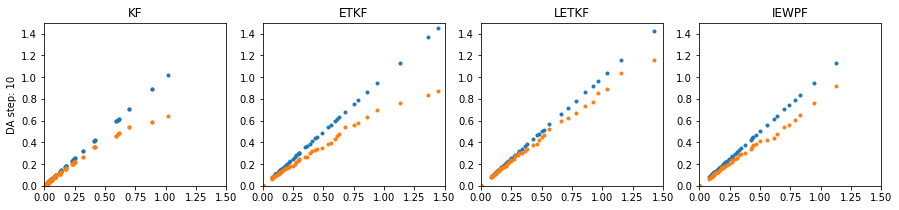

In [40]:
T = 10

fig, axs = plt.subplots(1, 4, figsize=(15,3))

axs[0].set_ylabel("DA step: " + str(T))
kf_prior_w = np.sort(np.linalg.eig(kf_prior_covs[T])[0])
kf_posterior_w = np.sort(np.linalg.eig(kf_posterior_covs[T])[0])
axs[0].plot(kf_prior_w, kf_prior_w, ".")
axs[0].plot(kf_prior_w, kf_posterior_w, ".")
axs[0].set_title("KF")

etkf_prior_w = np.sort(np.linalg.eig(estimateCov(prior_states_etkf[T]))[0])
etkf_posterior_w = np.sort(np.linalg.eig(estimateCov(posterior_states_etkf[T]))[0])

letkf_prior_w = np.sort(np.linalg.eig(estimateCov(prior_states_letkf[T]))[0])
letkf_posterior_w = np.sort(np.linalg.eig(estimateCov(posterior_states_letkf[T]))[0])

iewpf_prior_w = np.sort(np.linalg.eig(estimateCov(prior_states_iewpf[T]))[0])
iewpf_posterior_w = np.sort(np.linalg.eig(estimateCov(posterior_states_iewpf[T]))[0])


axs[1].plot(etkf_prior_w, etkf_prior_w, ".")
axs[1].plot(etkf_prior_w, etkf_posterior_w, ".")
axs[1].set_title("ETKF")

axs[2].plot(letkf_prior_w, letkf_prior_w, ".")
axs[2].plot(letkf_prior_w, letkf_posterior_w, ".")
axs[2].set_title("LETKF")

axs[3].plot(iewpf_prior_w, iewpf_prior_w, ".")
axs[3].plot(iewpf_prior_w, iewpf_posterior_w, ".")
axs[3].set_title("IEWPF")

for i in range(4):
    axs[i].set_ylim((0,1.5))
    axs[i].set_xlim((0,1.5))

In [42]:
np.savetxt("eigKFpriorT.csv", np.real(np.vstack([kf_prior_w, kf_prior_w]).T),delimiter=' ', newline='\n',  fmt='%1.8f')
np.savetxt("eigKFposteriorT.csv", np.real(np.vstack([kf_prior_w, kf_posterior_w]).T),delimiter=' ', newline='\n',  fmt='%1.8f')

np.savetxt("eigETKFpriorT.csv", np.real(np.vstack([etkf_prior_w, etkf_prior_w]).T),delimiter=' ', newline='\n',  fmt='%1.8f')
np.savetxt("eigETKFposteriorT.csv", np.real(np.vstack([etkf_prior_w, etkf_posterior_w]).T),delimiter=' ', newline='\n',  fmt='%1.8f')

np.savetxt("eigLETKFpriorT.csv", np.real(np.vstack([letkf_prior_w, letkf_prior_w]).T),delimiter=' ', newline='\n',  fmt='%1.8f')
np.savetxt("eigLETKFposteriorT.csv", np.real(np.vstack([letkf_prior_w, letkf_posterior_w]).T),delimiter=' ', newline='\n',  fmt='%1.8f')

np.savetxt("eigIEWPFpriorT.csv", np.real(np.vstack([iewpf_prior_w, iewpf_prior_w]).T),delimiter=' ', newline='\n',  fmt='%1.8f')
np.savetxt("eigIEWPFposteriorT.csv", np.real(np.vstack([iewpf_prior_w, iewpf_posterior_w]).T),delimiter=' ', newline='\n',  fmt='%1.8f')